# Xtrack Exciter beam element demo

This notebook demonstrates a very basic use of the new Xtrack Exciter beam element, introduced by Philipp Niedermayer (GSI) in [Xtrack PR #279](https://github.com/Xsuite/Xtrack/pull/279)

In [1]:
import xtrack as xt
import xpart as xp
import xobjects as xo

import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp

import json

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


The lattice used for this demo is the [PS East Slow Extraction scenario lattice from acc-models-ps](https://gitlab.cern.ch/acc-models/acc-models-ps/-/tree/2022/scenarios/east/4_slow_extraction), modified to be close to $Q_x=6.325$ using PFW matching

In [2]:
with open('ps_at_q_6_325 copy.json') as f:
    line_dict = json.load(f)
line = xt.Line.from_dict(line_dict)

Done loading line from dict.           


In [3]:
print(f"Line =\tCERN PS")
print(f"Beam =\tProton")
print(f"mass =\t{line.particle_ref.mass0} [eV] (rest mass)")
print(f"chrg =\t{line.particle_ref.q0} [e] (charge)")
print(f"p*c =\t{line.particle_ref.p0c[0]} [eV] (momentum)")
print(f"beta =\t{line.particle_ref.beta0[0]} (relativistic beta)")
print(f"gamma =\t{line.particle_ref.gamma0[0]} (relativistic gamma)")

Line =	CERN PS
Beam =	Proton
mass =	938272088.1604904 [eV] (rest mass)
chrg =	1.0 [e] (charge)
p*c =	291174000000.0 [eV] (momentum)
beta =	0.9999948081871252 (relativistic beta)
gamma =	310.3316355702626 (relativistic gamma)


In [4]:
initial_line = line.copy()
initial_tracker = initial_line.build_tracker()
initial_twiss = initial_tracker.twiss(method='4d')
print(f"Qx = \t{initial_twiss['qx']} (horizontal tune)")
print(f"Qy = \t{initial_twiss['qy']} (vertical tune)")


generating ./e3711c4766ce494b90c3eee788ced2a5.c
the current directory is '/Users/ash/cern/dev/md9044/analysis/simulation'
Qx = 	6.325186740243226 (horizontal tune)
Qy = 	6.204268099891988 (vertical tune)


This function uses [`scipy.signal.chirp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.chirp.html) to generate the chirp signal for the exciter.

1. It first creates a single chirp, between the given start and stop frequencies, for a specified number of turns (at a specified turn frequency).
2. Then it fills the remaining time until the next chirp (chirp repetition time / interval time) with zeros
3. It then repeats this signal for the number of times specified

This aims to be comparable with the chirp generation provided by the [Qmeter Application](https://wikis.cern.ch/display/ELENAOP/Tune+Measurement+tutorial), used to interface with CERN's various Base Band Q measurement systems, and used to drive RFKO in the PS.

In [5]:
def generate_chirp_signal(
        chirp_turns=256,
        chirp_repetitions=500,
        chirp_rep_time=0.001,
        turn_freq=470151.0308,
        chirp_start_freq=2e4,
        chirp_stop_freq=8e4,
        sampling_freq=1e6):
    """
    Generate a chirp signal for the simulation.
    ---
    Returns:
    time_samples: np.ndarray [s]
        Time samples of the signal
    signal_samples: np.ndarray [1]
        Signal samples
    total_turns: float [1]
        Total number of turns in the signal
    ---
    Parameters:
    chirp_turns: int [1]
        Number of turns that one chirp lasts for. Default: 256
    chirp_repetitions: [1]
        Number of chirp repetitions. Default: 500
    chirp_rep_time: float [s]
        Time between chirp repetitions. Default: 0.001 (1ms)
    turn_freq: float [Hz]
        Frequency of one turn in the machine. Default: 470151.0308
    chirp_start_freq: float [Hz]
        Start frequency of the chirp. Default: 2e4
    chirp_stop_freq: float [Hz]
        Stop frequency of the chirp. Default: 8e4
    sampling_freq: float [Hz]
        Sampling frequency of the signal. Default: 1e6
    """
    #   ▲
    #   │                   repetitions
    #   ├───────────────────────────────────────────────────►|
    #   │  rep time
    #   ├──────────►|
    # f │n turns
    # r ├──────►|
    # e │     ┌─         ┌─         ┌─         ┌─         ┌─
    # q │    ┌┘         ┌┘         ┌┘         ┌┘         ┌┘
    # u │   ┌┘         ┌┘         ┌┘         ┌┘         ┌┘
    # e │  ┌┘         ┌┘         ┌┘         ┌┘         ┌┘
    # n │ ┌┘         ┌┘         ┌┘         ┌┘         ┌┘
    # c ├─┘         ─┘         ─┘         ─┘         ─┘
    # y │
    #   │
    #   └───────────────────────────────────────────────────────────►
    #     t i m e

    # Calculate total signal time = time of one repetition * number of repetitions
    total_signal_time = chirp_repetitions * chirp_rep_time
    # Calculate the signal time for one chirp
    chirp_length_time = chirp_turns / turn_freq
    # Generate one chirp
    chirp_time_samples = np.arange(0, chirp_length_time, 1/sampling_freq)
    chirp_signal_samples = sp.signal.chirp(chirp_time_samples, chirp_start_freq, chirp_length_time, chirp_stop_freq)

    # Generate one repetition
    rep_time_samples = np.arange(0, chirp_rep_time, 1/sampling_freq)[:-1] # cut off the end for the next repetition
    rep_signal_samples = np.pad(chirp_signal_samples, 
                                (0, int(chirp_rep_time * sampling_freq - chirp_length_time * sampling_freq)), 
                                'constant', 
                                constant_values=(0, 0))
    
    # Generate full signal
    time_samples = np.arange(0, total_signal_time, 1/sampling_freq)[:-1] # cut off the end for the next repetition
    signal_samples = np.pad(
        rep_signal_samples,
        (0, len(rep_signal_samples)*(chirp_repetitions-1)-1),
        'wrap'
    )

    # calculate the number of turns
    total_time = chirp_rep_time * chirp_repetitions
    total_turns = total_time * turn_freq
    return time_samples, signal_samples, total_turns

The following simulation parameters are **not** physically accurate to extraction performed at the PS, and only used for a good example.

In [6]:
# Set up simulation parameters
N_TURN = int( 5e3 ) # number of turns for simulation
N_PART = int( 5e2 ) # number of particles for simulation

# Frequency of samples for the exciter (!= n*revolution_frequency)
# Revolution frequency from twiss
EXCITER_SAMPLING_FREQ = 1e6
FREV = 1/initial_twiss['T_rev']

# Set up particle distribution parameters
bunch_intensity = 1e11
sigma_z = 22.5e-2
nemitt_x = 2e-6
nemitt_y = 2.5e-6

In [7]:
ctx = xo.ContextCpu()
# ctx = xo.ContextCupy() for NVIDIA GPU
# ctx = xo.ContextPyopencl() for AMD/ARM GPU

# Create exciter object
exciter_time, exciter_signal, _ = generate_chirp_signal(turn_freq=FREV, sampling_freq=EXCITER_SAMPLING_FREQ)
exciter = xt.Exciter(
    _context = ctx,
    samples = exciter_signal,
    sampling = EXCITER_SAMPLING_FREQ,
    frev = FREV,
    start_turn = 0,
    knl = [.001]
)

# Create monitor at septum location
smh57_monitor = xt.ParticlesMonitor(
    _context = ctx,
    num_particles = N_PART,
    start_at_turn = 0,
    stop_at_turn = N_TURN
)

# Create new line with exciter and monitor
line.insert_element(
    element = smh57_monitor,
    name = 'SMH57_MONITOR',
    index = 'pe.smh57'
)
line.insert_element(
    element = exciter,
    name = "EXCITER",
    index='pr.kfb97'
)

# Build new tracker with exciter and monitor at septum
tracker = line.build_tracker()

generating ./9652d3128a9d4b4ab4b1d77e2b629fe1.c
the current directory is '/Users/ash/cern/dev/md9044/analysis/simulation'


In [8]:
# Create normalised particle distribution
x_in_sigmas, px_in_sigmas = xp.generate_2D_gaussian(N_PART)

particles = tracker.build_particles(
            x_norm=x_in_sigmas, px_norm=px_in_sigmas,
            nemitt_x=nemitt_x, nemitt_y=nemitt_y, method='4d')


In [9]:
# Perform tracking
tracker.track(
    particles=particles,
    num_turns=N_TURN
)

This gif animates horizontal phase-space turn by turn, showing the particles extracted by an abritrary septum at $x=0.15$. 

The extracted particles are shown in red, and persist after extraction.

<img src="demo copy.gif" width=400 height=400>

200
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448


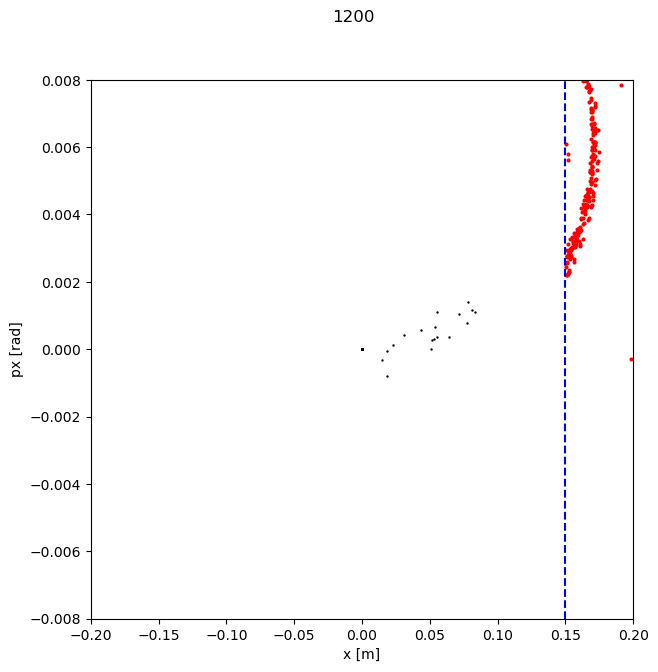

In [11]:
from matplotlib.animation import FuncAnimation, PillowWriter

fig, ax = plt.subplots(figsize=(7, 7), tight_layout=False)

def animate(i):
    print(i)
    ax.clear()

    SEPTA = 0.15

    ax.set_xlim(-0.2, 0.2)
    ax.set_ylim(-0.008, 0.008)
    fig.suptitle(f"{i:>4}")

    ax.scatter(
        ma.masked_array(smh57_monitor.x.T[i], mask=smh57_monitor.x.T[i] > SEPTA),
        ma.masked_array(smh57_monitor.px.T[i], mask=smh57_monitor.x.T[i] > SEPTA),
        marker='.', s=2, color='k')

    culm_x = ma.masked_array([])
    culm_px = ma.masked_array([])
    for j in range(i):
        culm_x = ma.append(culm_x, ma.masked_array(smh57_monitor.x.T[j], mask=smh57_monitor.x.T[j] < SEPTA))
        culm_px = ma.append(culm_px, ma.masked_array(smh57_monitor.px.T[j], mask=smh57_monitor.x.T[j] < SEPTA))


    ax.scatter(culm_x, culm_px, marker='.', s=15, color='r')
    ax.axvline(x=SEPTA, color='b', linestyle='--')
    ax.set_xlabel("x [m]")
    ax.set_ylabel("px [rad]")

    return

ani = FuncAnimation(fig, animate, frames=range(200, 1201), interval=1, blit=False, repeat=False)
ani.save("demo.gif", writer=PillowWriter(fps=30))
